# OpenPOPCON MANTA example
Welcome! This is an example usage of the OpenPOPCON scoping tool for the [MANTA](https://iopscience.iop.org/article/10.1088/1361-6587/ad6708) tokamak.

In [1]:
import sys
import pathlib
OP_HOME = '../../../'
sys.path.append(str(pathlib.Path(OP_HOME).resolve())) 
#–––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––
# ^^^ This must be done to import the openpopcon module from the src directory.
# When running this from another directory, change the OP_HOME variable to the
# path of the openpopcon directory.
#–––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––
import numpy as np
from src import openpopcon as op

## Setup
The POPCON object requires three settings files in the yaml format.
The first, 'settingsfile', contains the physical parameters for the tokamak, as well as algorithm information. 
The second, 'plotsettingsfile', contains the settings for the plots. This can be updated after plotting to change the appearance of the plots, without restarting the jupyter notebook.
The third, 'scalinglawfile', you will not necessarily need to change, but it contains the confinement time $\tau_E$ scaling laws for the simulation.

When you run this on your own, it is recommended that you copy the first two settings files and modify them to suit your needs; you can leave scalinglawfile as is.

In [2]:
settingsfile = "./POPCON_input_example.yaml"
plotsettingsfile = "./plotsettings.yml"
scalinglawfile = f"{OP_HOME}/resources/scalinglaws.yml"

pc = op.POPCON(settingsfile=settingsfile, 
               plotsettingsfile=plotsettingsfile, 
               scalinglawfile=scalinglawfile)

Impurity fractions = [0.025      0.         0.00170729 0.         0.         0.        ] calculated from Zeff_target.


## Running the code

To run the code, simply run the cell below. This will run the simulation.

OpenPOPCON uses numba 'just in time' (jit) compilation to speed up the simulation. This means that the first time you run the simulation, it will take a little longer to compile the code. Subsequent runs will be faster, until you restart the jupyter notebook kernel, at which the compilation will be required again.

In [3]:
# # This runs the POPCON

# pc.settings.verbosity = 0

# pc.settings.parallel = True
# %timeit pc.run_POPCON()

# pc.settings.parallel = False
# %timeit pc.run_POPCON()

pc.run_POPCON()


Setting up algorithm object
Solving power balance equations
Power balance solutions found. Populating output arrays.


## Plotting
The POPCON object has a method, 'plot', which will plot the results of the simulation. This method takes the settings from the 'plotsettingsfile' and plots the results. You can modify the 'plotsettingsfile' and rerun both 'update_plotsettings' and the plot method to see the changes.

There is also the method 'custom_plot' which allows you to plot any array on top of the simulation results. This can be useful if you have a specific quantity that is not calculated by default.

Plotting Paux with levels [1.0e-01 1.0e+00 1.0e+01 2.5e+01 5.0e+01 1.0e+02 5.0e+02 2.0e+03] and options ['r', 3, '$P_{aux}$', 12, '%.2d']
Plotting Pfusion with levels [ 100.  200.  500. 1000. 2000. 4000.] and options ['k', 2, '$P_{fus}$', 12, '%.2d']
Plotting Prad with levels [ 10.  50. 100. 200.] and options ['purple', 2, '$P_{rad}$', 12, '%.2d']
Plotting Q with levels [  0.5   1.    2.    5.   10.   25.   50.  100. ] and options ['orange', 2, '$Q$', 12, '%.f']
Plotting H98 with levels [0.14971489 0.21321968 0.27672448 0.34022928 0.40373408] and options ['blue', 2, '$H_{98y2}$', 12, '%.1f']
Plotting betaN with levels [0.04651495 1.25062965 2.45474436 3.65885906 4.86297377] and options ['forestgreen', 2, '$\\beta_N$', 12, '%.2f']


/var/folders/x2/jvlxwqv16l13l4_x14rwbsxh0000gn/T/ipykernel_13682/55148306.py:12: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


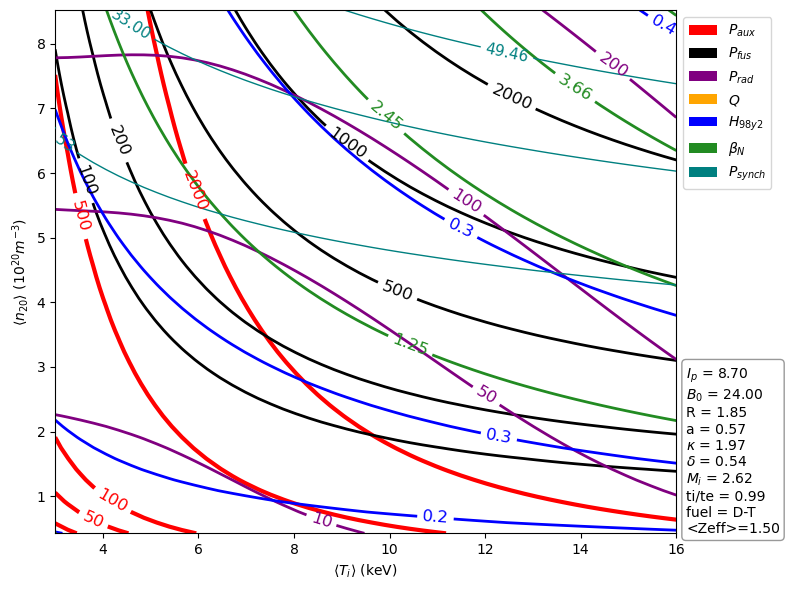

In [4]:
pc.update_plotsettings()
fig, ax = pc.plot(show=False)

# Example of how to plot a custom quantity
P_synchotron = np.empty((pc.settings.Nn, pc.settings.NTi))
rho = pc.algorithms.sqrtpsin
for i in range(pc.settings.Nn):
    for j in range(pc.settings.NTi):
        P_synchotron[i,j] = pc.algorithms.volume_integral(rho, pc.algorithms._P_brem_rad(rho, pc.output.T_e_max[j], pc.output.n_e_20_max[i]))
pc.custom_plot(fig, ax, P_synchotron, np.linspace(np.min(P_synchotron), np.max(P_synchotron), 5), 'teal', 1., r'$P_{synch}$')
ax.legend(bbox_to_anchor=(1, 1), loc='upper left')
fig.show()

In [5]:
def single_point(n_G_frac:float, Ti_av:float, plot:bool=True, show:bool=True) -> None:
    n_G = pc.algorithms.n_GR
    rho = pc.algorithms.sqrtpsin
    n_e_avg_fac = pc.algorithms.volume_integral(rho,pc.algorithms.get_profile(rho, 1))/pc.algorithms.V
    n_e_20 = n_G_frac*n_G/n_e_avg_fac
    T_i_avg_fac = pc.algorithms.volume_integral(rho, pc.algorithms.get_profile(rho, 3))/pc.algorithms.V
    n_i_avg_fac = pc.algorithms.volume_integral(rho, pc.algorithms.get_profile(rho, 2))/pc.algorithms.V
    T_i_keV = Ti_av/T_i_avg_fac
    T_e_keV = T_i_keV/pc.algorithms.tipeak_over_tepeak
    
    dil = pc.algorithms.plasma_dilution(T_e_keV)
    n_i_20 = n_e_20*dil
    line_avg_fac = np.average(pc.algorithms.get_profile(rho, 1))


    Paux = pc.algorithms.P_aux_relax_impfrac(n_e_20,T_i_keV,pc.settings.accel,pc.settings.err,pc.settings.maxit)
            
    Pfusion = pc.algorithms.volume_integral(rho,pc.algorithms._P_fusion(rho, T_i_keV, n_i_20))
    Pfusion_heating = pc.algorithms.volume_integral(rho,pc.algorithms._P_fusion_heating(rho, T_i_keV, n_i_20))
    Pohmic = pc.algorithms.volume_integral(rho,pc.algorithms._P_OH_prof(rho, T_e_keV, n_e_20))
    Pbrems = pc.algorithms.volume_integral(rho,pc.algorithms._P_brem_rad(rho, T_e_keV, n_e_20))
    Psynch = pc.algorithms.volume_integral(rho,pc.algorithms._P_synch(rho, T_e_keV, n_e_20))
    Pimprad = pc.algorithms.volume_integral(rho,pc.algorithms._P_impurity_rad(rho, T_e_keV, n_e_20))
    Prad = pc.algorithms.volume_integral(rho,pc.algorithms._P_rad(rho, T_e_keV, n_e_20))
    Pheat = Pfusion_heating + Pohmic + Paux - Pbrems
    Palpha = pc.algorithms.volume_integral(rho,pc.algorithms._P_DTnHe4_prof(rho, T_i_keV, n_i_20))*3.52e3/(3.52e3 + 14.06e3)
    Pdd = pc.algorithms.volume_integral(rho,pc.algorithms._P_DDnHe3_prof(rho, T_i_keV, n_i_20))
    Pdd += pc.algorithms.volume_integral(rho,pc.algorithms._P_DDpT_prof(rho, T_i_keV, n_i_20))
    Pdt = pc.algorithms.volume_integral(rho,pc.algorithms._P_DTnHe4_prof(rho, T_i_keV, n_i_20))

    tauE = pc.algorithms.tauE_scalinglaw(Pheat, n_e_20*line_avg_fac)

    if pc.settings.scalinglaw == "ISSO_fake":
        print(f"[DEBUG] Using ISSO_fake scaling: tau_E = {tauE:.4f}")
    else:
        print(f"[DEBUG] Using {pc.settings.scalinglaw} scaling: tau_E = {tauE:.4f}")
    print(f"[DEBUG] Scaling law selected: {pc.settings.scalinglaw}")
    
single_point(n_G_frac=0.37, Ti_av=7.3)

[DEBUG] Using ISSO scaling: tau_E = 0.0156
[DEBUG] Scaling law selected: ISSO


## Scoping operation points

POPCONs, or 'Plasma OPerating CONtours', show a wide range of operating points for a given tokamak. The 'single_point' method lets you explore a single pair of density/temperatures, and look at the resulting profiles. 


Params:
n_i_average = 2.918292809630607 x 10^20 m^-3
n_e_average = 3.154 x 10^20 m^-3
n_G = 8.524 x 10^20 m^-3
n_i_axis = 3.967 x 10^20 m^-3
n_e_axis = 4.287 x 10^20 m^-3
Ti_average = 7.3 keV
Ti_axis = 20.0 keV
Solution:
P_aux = 1718.79 MW
P_fusion = 159.55 MW
P_SOL = 1731.13 MW
P_load = 27.989 MW/m^2
P_ohmic = 0.002 MW
P_brems = 6.072 MW
P_synch = 14.922 MW
P_imprad = 7.781 MW
P_rad = 28.78 MW
P_heat = 1744.75 MW
P_alpha = 31.91 MW
P_dd = 0.184 MW
P_dt = 159.37 MW
Wtot/TauE = 1738.91 MW
f_rad = 0.016 
tauE = 0.016 s
Q = 0.093 
H89 = 0.25
H98 = 0.28
vloop = 0.0002 V
betaN = 0.829



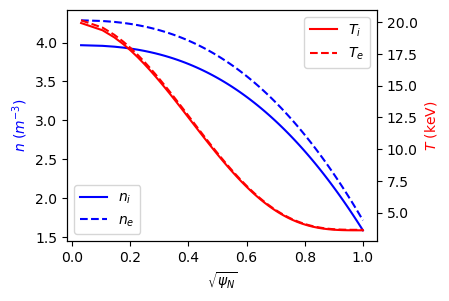

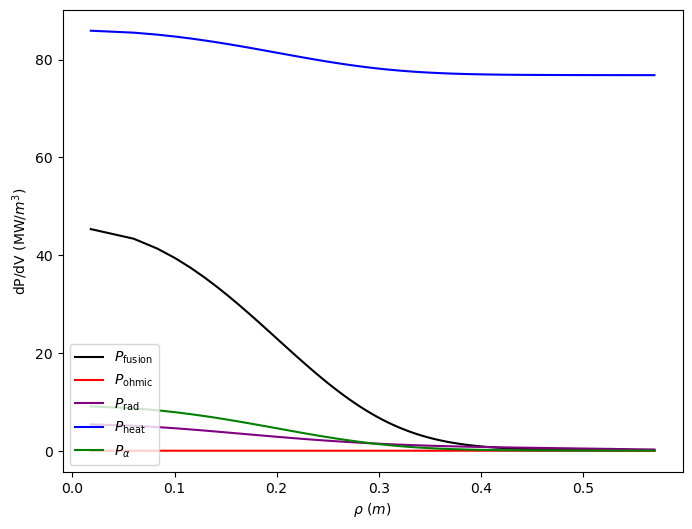

In [6]:
pc.single_point(n_G_frac=0.37,Ti_av=7.3)


Params:
n_i_average = 2.918292809630607 x 10^20 m^-3
n_e_average = 3.154 x 10^20 m^-3
n_G = 8.524 x 10^20 m^-3
n_i_axis = 3.967 x 10^20 m^-3
n_e_axis = 4.287 x 10^20 m^-3
Ti_average = 7.3 keV
Ti_axis = 20.0 keV
Solution:
P_aux = 1718.79 MW
P_fusion = 159.55 MW
P_SOL = 1731.13 MW
P_load = 27.989 MW/m^2
P_ohmic = 0.002 MW
P_brems = 6.072 MW
P_synch = 14.922 MW
P_imprad = 7.781 MW
P_rad = 28.78 MW
P_heat = 1744.75 MW
P_alpha = 31.91 MW
P_dd = 0.184 MW
P_dt = 159.37 MW
Wtot/TauE = 1738.91 MW
f_rad = 0.016 
tauE = 0.016 s
Q = 0.093 
H89 = 0.25
H98 = 0.28
vloop = 0.0002 V
betaN = 0.829



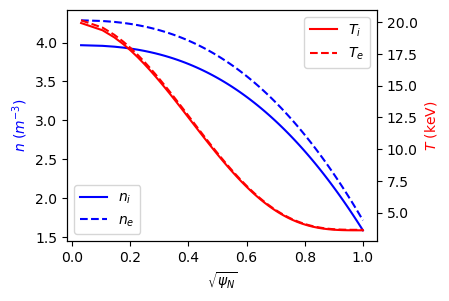

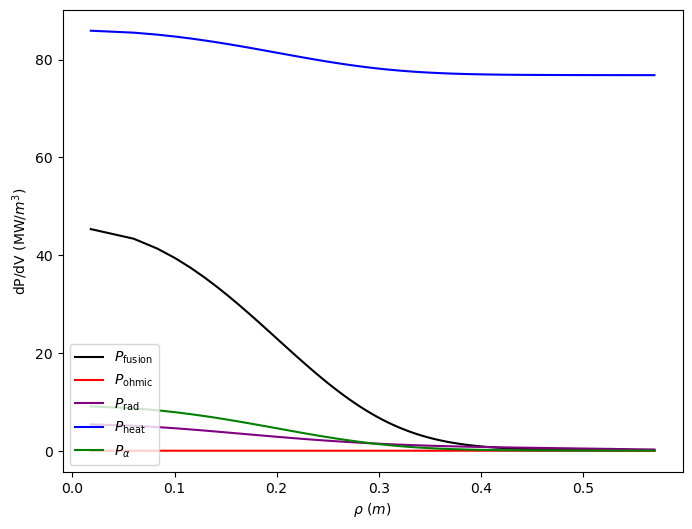

In [7]:
pc.single_point(n_G_frac=0.37,Ti_av=7.3)

## Reading and writing outputs

Running this simulation large quantities of times can be time consuming. Saving and loading of POPCON outputs is enabled so that you can save the results of a simulation and load them later to edit the plots. Outputs are saved to the 'outputs' directory as either a folder or a zip archive. See below.

In [8]:
pc.write_output(name='sparc_test',archive=False,overwrite=True)

Plotting Paux with levels [1.0e-01 1.0e+00 1.0e+01 2.5e+01 5.0e+01 1.0e+02 5.0e+02 2.0e+03] and options ['r', 3, '$P_{aux}$', 12, '%.2d']
Plotting Pfusion with levels [ 100.  200.  500. 1000. 2000. 4000.] and options ['k', 2, '$P_{fus}$', 12, '%.2d']
Plotting Prad with levels [ 10.  50. 100. 200.] and options ['purple', 2, '$P_{rad}$', 12, '%.2d']
Plotting Q with levels [  0.5   1.    2.    5.   10.   25.   50.  100. ] and options ['orange', 2, '$Q$', 12, '%.f']
Plotting H98 with levels [0.14971489 0.21321968 0.27672448 0.34022928 0.40373408] and options ['blue', 2, '$H_{98y2}$', 12, '%.1f']
Plotting betaN with levels [0.04651495 1.25062965 2.45474436 3.65885906 4.86297377] and options ['forestgreen', 2, '$\\beta_N$', 12, '%.2f']


Impurity fractions = [0.025      0.         0.00170729 0.         0.         0.        ] calculated from Zeff_target.
Plotting Paux with levels [1.0e-01 1.0e+00 1.0e+01 2.5e+01 5.0e+01 1.0e+02 5.0e+02 2.0e+03] and options ['r', 3, '$P_{aux}$', 12, '%.2d']
Plotting Pfusion with levels [ 100.  200.  500. 1000. 2000. 4000.] and options ['k', 2, '$P_{fus}$', 12, '%.2d']
Plotting Prad with levels [ 10.  50. 100. 200.] and options ['purple', 2, '$P_{rad}$', 12, '%.2d']
Plotting Q with levels [  0.5   1.    2.    5.   10.   25.   50.  100. ] and options ['orange', 2, '$Q$', 12, '%.f']
Plotting H98 with levels [0.14971489 0.21321968 0.27672448 0.34022928 0.40373408] and options ['blue', 2, '$H_{98y2}$', 12, '%.1f']
Plotting betaN with levels [0.04651495 1.25062965 2.45474436 3.65885906 4.86297377] and options ['forestgreen', 2, '$\\beta_N$', 12, '%.2f']


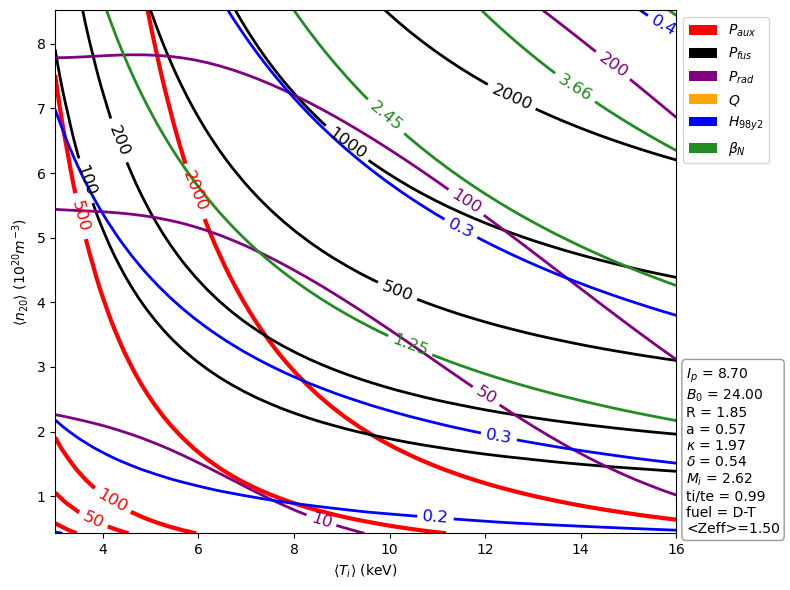

(<Figure size 800x600 with 1 Axes>,
 <Axes: xlabel='$\\langle T_i\\rangle$ (keV)', ylabel='$\\langle n_{20}\\rangle$ ($10^{20} m^{-3}$)'>)

In [9]:
pcread = op.POPCON()
pcread.read_output('sparc_test')
pcread.plot()

In [10]:
print (pc)